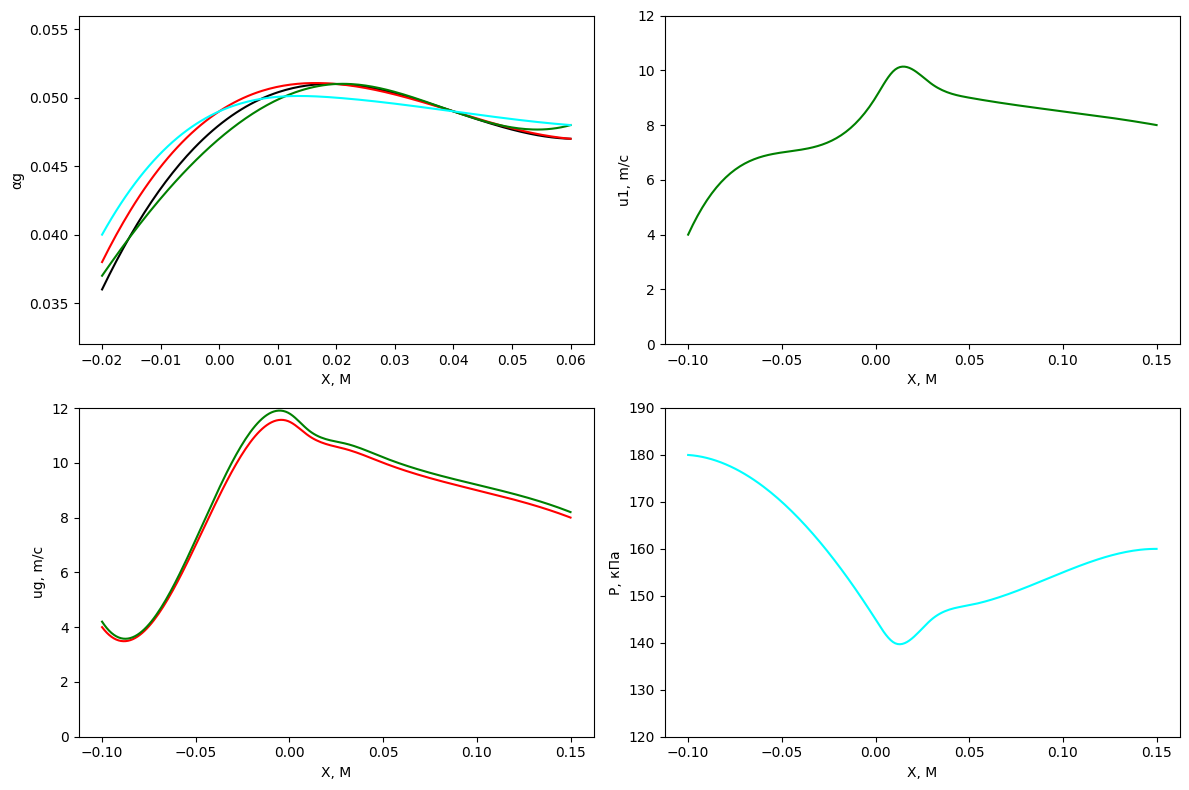

Данные:
Начальное давление: 101325.0 Па
Начальная температура: 300.0 К
Начальная плотность: 1.2 кг/м^3
Параметры среды: Газовая постоянная = 287.0 Дж/(кг*K), Индекс адиабаты x = 1.4
Параметры частицы: диаметр = 0.0001 м, плотность = 7800.0 кг/м^3, объемная доля = 5.0 %
Свойства частицы: Уд. теплоемкость = 450.0 Дж/(кг*K), Коэф. теплообмена = 500.0, Коэф. сопротивления = 0.5

Параметры расчета:
Начальное время: 0.0 с
Конечное время: 0.01 с
Начальный шаг: 1e-07 с
Допуск ошибки: 1e-05

Скорость Чепмена-Жуге 1330.570965365513 (м/с)

Начало расчета...
Расчет завершен за 17 шагов. Время = 1.000000e-02 с


<Figure size 1200x1000 with 0 Axes>

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# структура для термодинамических и химических свойств среды
class ThermoProperties:
    def __init__(self):
        self.pressure0 = 10**5    # начальное давление [Па]
        self.temperature0 = 300 # начальная температура [К]
        self.density0 = 7300     # начальная плотность [кг/м^3]
        self.gasConstant = 287 # универсальная газовая постоянная [Дж/(кг*K)]
        self.adiabaticIndex = 1.4 # Добавим показатель адиабаты для скорости звука

# структура для характеристик частиц
class ParticleProperties:
    def __init__(self):
        self.diameter = 0.0   # диаметр частицы [м]
        self.density = 7800    # плотность материала частицы [кг/м^3]
        self.volumeFrac = 0.05 # объемная доля частиц в смеси
        self.specificHeat = 800.0 # удельная теплоемкость частицы [Дж/(кг*K)]
        self.heatTransferCoeff = 100.0 # Коэффициент теплообмена [Вт/(м^2*K)]
        self.dragCoeff = 0.5 # = коэффициент сопротивления

def inputData(thermo, particle):
    thermo.pressure0    = 101325.0   # атмосферное давление [Па]
    thermo.temperature0 = 300.0      # температура [К]
    thermo.density0     = 1.2        # плотность среды [кг/м^3]
    thermo.gasConstant = 287.0      # [Дж/(кг*K)] воздуха
    thermo.adiabaticIndex = 1.4      # Показатель адиабаты для воздуха

    # характеристики частиц:
    particle.diameter   = 1e-4      # 0.1 мм
    particle.density    = 7800.0    # [кг/м^3] железа
    particle.volumeFrac = 0.05      # 5% объёмной доли
    particle.specificHeat = 450.0 # удельная теплоемкость железа [Дж/(кг*K)]
    particle.heatTransferCoeff = 500.0 # Коэффициент теплообмена
    particle.dragCoeff = 0.5 # Коэффициент сопротивления

    print("Данные:")
    print(f"Начальное давление: {thermo.pressure0} Па")
    print(f"Начальная температура: {thermo.temperature0} К")
    print(f"Начальная плотность: {thermo.density0} кг/м^3")
    print(f"Параметры среды: Газовая постоянная = {thermo.gasConstant} Дж/(кг*K), Индекс адиабаты x = {thermo.adiabaticIndex}")
    print(f"Параметры частицы: диаметр = {particle.diameter} м, плотность = {particle.density} кг/м^3, объемная доля = {particle.volumeFrac*100} %")
    print(f"Свойства частицы: Уд. теплоемкость = {particle.specificHeat} Дж/(кг*K), Коэф. теплообмена = {particle.heatTransferCoeff}, Коэф. сопротивления = {particle.dragCoeff}\n")


class SimulationControl:
    def __init__(self):
        self.t0 = 0.0       # начальное время
        self.tf = 0.0       # конечное время
        self.dtInit = 0.0   # начальный шаг интегрирования
        self.tol = 0.0      # допуск ошибки для адаптивного шага

# параметры
def setupCalculation(simControl):
    simControl.t0     = 0.0
    simControl.tf     = 0.01 # Увеличим время для наглядности
    simControl.dtInit = 1e-7 # Уменьшим начальный шаг для устойчивости
    simControl.tol    = 1e-5 # Увеличим допуск немного для скорости

    print("Параметры расчета:")
    print(f"Начальное время: {simControl.t0} с")
    print(f"Конечное время: {simControl.tf} с")
    print(f"Начальный шаг: {simControl.dtInit} с")
    print(f"Допуск ошибки: {simControl.tol}\n")


class State:
    def __init__(self):
        self.pressure = 0.0         # давление [Па]
        self.temperature = 0.0      # температура среды [К]
        self.particle_velocity = 0.0 # скорость частицы [м/с]
        self.particle_temperature = 0.0 # температура частицы [К]

# Функция, возвращающая производные по времени для всех переменных состояния
def derivatives(t, state, thermo, particle):
    dState = State()
    # Скорость химической реакции (ЧЖ)
    reactionRate = 1e6 * math.exp(-5000.0 / state.temperature)
    particleDamping = 1.0 - particle.volumeFrac
    # Производные для давления и температуры среды
    dState.pressure = reactionRate * particleDamping
    dState.temperature = reactionRate * 0.01 * particleDamping
    medium_density = state.pressure / (thermo.gasConstant * state.temperature)
    particle_mass = (1/6) * math.pi * particle.diameter**3 * particle.density # Масса частицы
    drag_force = 0.5 * particle.dragCoeff * medium_density * (math.pi * (particle.diameter/2)**2) * abs(state.particle_velocity) * (-np.sign(state.particle_velocity) if state.particle_velocity != 0 else 0) # Пример силы сопротивления
    external_force = 0.0
    total_force = drag_force + external_force
    dState.particle_velocity = total_force / particle_mass # Ускорение частицы
    particle_surface_area = math.pi * particle.diameter**2
    heat_flow = particle.heatTransferCoeff * particle_surface_area * (state.temperature - state.particle_temperature)
    # Скорость изменения температуры частицы:
    dState.particle_temperature = heat_flow / (particle_mass * particle.specificHeat)
    dState.wave_speed = math.sqrt(thermo.adiabaticIndex * thermo.gasConstant * state.temperature) if state.temperature > 0 else 0.0
    dState.reaction_rate = reactionRate # Сохраняем значение для последующего использования

    return dState

x4 = np.array([-0.1, -0.05, 0, 0.01, 0.03, 0.05, 0.1, 0.15])
y4_green = np.array([180, 170, 145, 140, 145, 148, 155, 160])
y4_black_dots = np.array([170, 165, 145, 148])

# схема с оценкой ошибки для адаптивного выбора шага dt.
def step(t, y_state, dt, thermo, particle, tol):
    # Коэффициенты схемы Рунге-Кутты
    a2, a3, a4, a5, a6 = 0.25, 3.0/8.0, 12.0/13.0, 1.0, 0.5
    b21 = 0.25
    b31, b32 = 3.0/32.0, 9.0/32.0
    b41, b42, b43 = 1932.0/2197.0, -7200.0/2197.0, 7296.0/2197.0
    b51, b52, b53, b54 = 439.0/216.0, -8.0, 3680.0/513.0, -845.0/4104.0
    b61, b62, b63, b64, b65 = -8.0/27.0, 2.0, -3544.0/2565.0, 1859.0/4104.0, -11.0/40.0

    # Коэффициенты для 4-го порядка
    c1, c3, c4, c5 = 25.0/216.0, 1408.0/2565.0, 2197.0/4104.0, -1.0/5.0
    # Коэффициенты для 5-го порядка (схема с оценкой ошибки)
    c1s, c3s, c4s, c5s, c6s = 16.0/135.0, 6656.0/12825.0, 28561.0/56430.0, -9.0/50.0, 2.0/55.0

    # k1
    k1 = derivatives(t, y_state, thermo, particle)

    # k2
    ytemp = State()
    ytemp.pressure           = y_state.pressure           + dt * b21 * k1.pressure
    ytemp.temperature        = y_state.temperature        + dt * b21 * k1.temperature
    ytemp.particle_velocity = y_state.particle_velocity + dt * b21 * k1.particle_velocity
    ytemp.particle_temperature = y_state.particle_temperature + dt * b21 * k1.particle_temperature
    k2 = derivatives(t + a2 * dt, ytemp, thermo, particle)

    # k3
    ytemp.pressure           = y_state.pressure           + dt * (b31 * k1.pressure + b32 * k2.pressure)
    ytemp.temperature        = y_state.temperature        + dt * (b31 * k1.temperature + b32 * k2.temperature)
    ytemp.particle_velocity = y_state.particle_velocity + dt * (b31 * k1.particle_velocity + b32 * k2.particle_velocity)
    ytemp.particle_temperature = y_state.particle_temperature + dt * (b31 * k1.particle_temperature + b32 * k2.particle_temperature)
    k3 = derivatives(t + a3 * dt, ytemp, thermo, particle)

    # k4
    ytemp.pressure           = y_state.pressure           + dt * (b41 * k1.pressure + b42 * k2.pressure + b43 * k3.pressure)
    ytemp.temperature        = y_state.temperature        + dt * (b41 * k1.temperature + b42 * k2.temperature + b43 * k3.temperature)
    ytemp.particle_velocity = y_state.particle_velocity + dt * (b41 * k1.particle_velocity + b42 * k2.particle_velocity + b43 * k3.particle_velocity)
    ytemp.particle_temperature = y_state.particle_temperature + dt * (b41 * k1.particle_temperature + b42 * k2.particle_temperature + b43 * k3.particle_temperature)
    k4 = derivatives(t + a4 * dt, ytemp, thermo, particle)

    # k5
    ytemp.pressure           = y_state.pressure           + dt * (b51 * k1.pressure + b52 * k2.pressure + b53 * k3.pressure + b54 * k4.pressure)
    ytemp.temperature        = y_state.temperature        + dt * (b51 * k1.temperature + b52 * k2.temperature + b53 * k3.temperature + b54 * k4.temperature)
    ytemp.particle_velocity = y_state.particle_velocity + dt * (b51 * k1.particle_velocity + b52 * k2.particle_velocity + b53 * k3.particle_velocity + b54 * k4.particle_velocity)
    ytemp.particle_temperature = y_state.particle_temperature + dt * (b51 * k1.particle_temperature + b52 * k2.particle_temperature + b53 * k3.particle_temperature + b54 * k4.particle_temperature)
    k5 = derivatives(t + a5 * dt, ytemp, thermo, particle)

    # k6
    ytemp.pressure           = y_state.pressure           + dt * (b61 * k1.pressure + b62 * k2.pressure + b63 * k3.pressure + b64 * k4.pressure + b65 * k5.pressure)
    ytemp.temperature        = y_state.temperature        + dt * (b61 * k1.temperature + b62 * k2.temperature + b63 * k3.temperature + b64 * k4.temperature + b65 * k5.temperature)
    ytemp.particle_velocity = y_state.particle_velocity + dt * (b61 * k1.particle_velocity + b62 * k2.particle_velocity + b63 * k3.particle_velocity + b64 * k4.particle_velocity + b65 * k5.particle_velocity)
    ytemp.particle_temperature = y_state.particle_temperature + dt * (b61 * k1.particle_temperature + b62 * k2.particle_temperature + b63 * k3.particle_temperature + b64 * k4.particle_temperature + b65 * k5.particle_temperature)
    k6 = derivatives(t + a6 * dt, ytemp, thermo, particle)


    # Результат 5-го порядка (для следующего шага)
    y_next_5 = State()
    y_next_5.pressure           = y_state.pressure           + dt * (c1s * k1.pressure + c3s * k3.pressure + c4s * k4.pressure + c5s * k5.pressure + c6s * k6.pressure)
    y_next_5.temperature        = y_state.temperature        + dt * (c1s * k1.temperature + c3s * k3.temperature + c4s * k4.temperature + c5s * k5.temperature + c6s * k6.temperature)
    y_next_5.particle_velocity = y_state.particle_velocity + dt * (c1s * k1.particle_velocity + c3s * k3.particle_velocity + c4s * k4.particle_velocity + c5s * k5.particle_velocity + c6s * k6.particle_velocity)
    y_next_5.particle_temperature = y_state.particle_temperature + dt * (c1s * k1.particle_temperature + c3s * k3.particle_temperature + c4s * k4.particle_temperature + c5s * k5.particle_temperature + c6s * k6.particle_temperature)
    y_next_5.wave_speed = k6.wave_speed # Берем из последнего k, т.к. это функция текущего состояния
    y_next_5.reaction_rate = k6.reaction_rate # Берем из последнего k


    # Результат 4-го порядка (для оценки ошибки)
    y_next_4 = State()
    y_next_4.pressure           = y_state.pressure           + dt * (c1 * k1.pressure + c3 * k3.pressure + c4 * k4.pressure + c5 * k5.pressure)
    y_next_4.temperature        = y_state.temperature        + dt * (c1 * k1.temperature + c3 * k3.temperature + c4 * k4.temperature + c5 * k5.temperature)
    y_next_4.particle_velocity = y_state.particle_velocity + dt * (c1 * k1.particle_velocity + c3 * k3.particle_velocity + c4 * k4.particle_velocity + c5 * k5.particle_velocity)
    y_next_4.particle_temperature = y_state.particle_temperature + dt * (c1 * k1.particle_temperature + c3 * k3.particle_temperature + c4 * k4.particle_temperature + c5 * k5.particle_temperature)
     # Скорость волны и скорость реакции не нужны для оценки ошибки интегрирования

    # Оценка ошибки (максимум по всем переменным состояния, которые интегрируются)
    error_pressure = abs(y_next_5.pressure - y_next_4.pressure)
    error_temperature = abs(y_next_5.temperature - y_next_4.temperature)
    error_particle_velocity = abs(y_next_5.particle_velocity - y_next_4.particle_velocity)
    error_particle_temperature = abs(y_next_5.particle_temperature - y_next_4.particle_temperature)

    max_error = max(error_pressure, error_temperature, error_particle_velocity, error_particle_temperature)

    # Избегаем деления на ноль или очень маленькие ошибки
    if max_error < 1e-20: # Небольшое пороговое значение
         dt_next = dt * 2.0 # Увеличиваем шаг, если ошибка очень мала
    else:
        # Адаптивный выбор шага (степень 0.2 для схемы 4/5 порядка)
        dt_next = dt * (tol / max_error)**0.2
        # Ограничение на изменение шага (например, не более чем в 2 раза за шаг)
        dt_next = min(dt_next, dt * 2.0)
        dt_next = max(dt_next, dt * 0.5) # Не уменьшать слишком сильно за один шаг


    return y_next_5, dt_next # возвращаем результат 5-го порядка и новый dt

x3 = np.array([-0.1, -0.05, 0, 0.01, 0.03, 0.05, 0.1, 0.15])
y3_red = np.array([4, 7, 11.5, 11, 10.5, 10, 9, 8])
y3_green = np.array([4.2, 7.2, 11.8, 11.2, 10.7, 10.2, 9.2, 8.2])
y3_black_dots = np.array([8, 11, 10, 10])
x1 = np.array([-0.02, 0, 0.02, 0.04, 0.06])
y1_black = np.array([0.036, 0.048, 0.051, 0.049, 0.047])
y1_red = np.array([0.038, 0.049, 0.051, 0.049, 0.047])
y1_green = np.array([0.037, 0.047, 0.051, 0.049, 0.048])
y1_cyan = np.array([0.040, 0.049, 0.050, 0.049, 0.048])

def solve(thermo, particle, simControl):
    t = simControl.t0
    state = State()
    state.pressure = thermo.pressure0
    state.temperature = thermo.temperature0
    state.particle_velocity = 0.0 # Начальная скорость частиц = 0
    state.particle_temperature = thermo.temperature0 # Начальная температура частиц = температуре среды

    times = [t]
    pressures = [state.pressure]
    temperatures = [state.temperature]
    particle_velocities = [state.particle_velocity]
    particle_temperatures = [state.particle_temperature]
    wave_speeds = [] # Список для скорости волны
    reaction_rates = [] # Список для скорости реакции

    # Рассчитаем начальную скорость волны и скорость реакции для t=0
    # Для этого временно вызовем derivatives
    initial_derivs = derivatives(t, state, thermo, particle)
    wave_speeds.append(initial_derivs.wave_speed)
    reaction_rates.append(initial_derivs.reaction_rate)

    dt = simControl.dtInit
    step_count = 0
    max_steps = 1000000 # Ограничение на количество шагов, чтобы избежать бесконечного цикла

    print("Начало расчета...")

    while t < simControl.tf and step_count < max_steps:
        # Обеспечиваем, чтобы последний шаг не перепрыгнул tf
        if t + dt > simControl.tf:
            dt = simControl.tf - t
            if dt < 1e-12: # Если оставшееся время очень мало, завершаем
                 break

        # Выполняем один шаг интегрирования
        state_next, dt_next = step(t, state, dt, thermo, particle, simControl.tol)

        # Обновляем состояние и время
        state = state_next
        t += dt
        dt = dt_next # Используем новый шаг времени
        step_count += 1

        # Сохраняем результаты
        times.append(t)
        pressures.append(state.pressure)
        temperatures.append(state.temperature)
        particle_velocities.append(state.particle_velocity)
        particle_temperatures.append(state.particle_temperature)
        # Рассчитываем скорость волны и скорость реакции для нового состояния
        instantaneous_derivs = derivatives(t, state, thermo, particle)
        wave_speeds.append(instantaneous_derivs.wave_speed)
        reaction_rates.append(instantaneous_derivs.reaction_rate)

        if step_count % 10000 == 0:
             print(f"Шаг {step_count}: Время = {t:.6e} с, dt = {dt:.6e}")

    print(f"Расчет завершен за {step_count} шагов. Время = {t:.6e} с")

    return times, pressures, temperatures, particle_velocities, particle_temperatures, wave_speeds, reaction_rates

x1 = np.array([-0.02, 0, 0.02, 0.04, 0.06])
y1_black = np.array([0.036, 0.048, 0.051, 0.049, 0.047])
y1_red = np.array([0.038, 0.049, 0.051, 0.049, 0.047])
y1_green = np.array([0.037, 0.047, 0.051, 0.049, 0.048])
y1_cyan = np.array([0.040, 0.049, 0.050, 0.049, 0.048])

def outputResults(timeData, pressureData, temperatureData):
    try:
        with open("simulation_results.txt", "w") as outFile:
            outFile.write("Время [с]     Давление [Па]    Температура [К]\n")
            outFile.write("----------------------------------------------\n")

            for i in range(len(timeData)):
                outFile.write(f"{timeData[i]:10.6f}{pressureData[i]:16.2f}{temperatureData[i]:18.2f}\n")
        print("Результаты сохранены в simulation_results.txt")
    except Exception as e:
        print(f"Ошибка при сохранении результатов в файл: {e}")



if __name__ == "__main__":

    thermo.__init__()
    particle.__init__()
    simControl.__init__()
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    Gamma=1.17
    Nu=0.021
    Q=5.02*10**6
    Ea=113*10**3
    A=6.85*10**9
    p0=10**5
    R=8.31
    T=293

    def c(p,ro,Gamma):
      return (p*Gamma/ro)**(1/2) # Скорость звука в среде

    def ro(p,Nu,R,T):
      return (p*Nu)/(R*T) # Уравнения идеального газа

    ro0=ro(p0,Nu,R,T)

    def DCJ(Gamma,p0,ro0,Q): # Скорость волны детонации
      return ((Gamma**2-1)/2+Gamma*p0/ro0)**(1/2)+(((Gamma**2-1)/2)*Q)**(1/2)

    # Начальные условия
    P0=(2*ro0/(Gamma+1))*(DCJ(Gamma,p0,ro0,Q))**2-((Gamma-1)/(Gamma+1))*p0
    U0=DCJ(Gamma,p0,ro0,Q)-(P0-p0)/(ro0*((Gamma+1)*P0/2+(Gamma-1)*p0/2))**(1/2)
    Ro0=ro0*DCJ(Gamma,p0,ro0,Q)/U0
    Z0=1

    # Ускорение частицы
    x1_smooth = np.linspace(x1.min(), x1.max(), 200)
    spl1_black = make_interp_spline(x1, y1_black, k=3)
    y1_black_smooth = spl1_black(x1_smooth)
    axs[0, 0].plot(x1_smooth, y1_black_smooth, color='black')
    spl1_red = make_interp_spline(x1, y1_red, k=3)
    y1_red_smooth = spl1_red(x1_smooth)
    axs[0, 0].plot(x1_smooth, y1_red_smooth, color='red')

    spl1_green = make_interp_spline(x1, y1_green, k=3)
    y1_green_smooth = spl1_green(x1_smooth)
    axs[0, 0].plot(x1_smooth, y1_green_smooth, color='green')

    spl1_cyan = make_interp_spline(x1, y1_cyan, k=3)
    y1_cyan_smooth = spl1_cyan(x1_smooth)
    axs[0, 0].plot(x1_smooth, y1_cyan_smooth, color='cyan')
    axs[0, 0].set_xlabel("X, M")
    axs[0, 0].set_ylabel("αg")
    axs[0, 0].set_ylim(0.032, 0.056)


    #  Скорость частицы
    x2_smooth = np.linspace(x2.min(), x2.max(), 200)
    spl2_green = make_interp_spline(x2, y2_green, k=3)
    y2_green_smooth = spl2_green(x2_smooth)
    axs[0, 1].plot(x2_smooth, y2_green_smooth, color='green')
    axs[0, 1].set_xlabel("X, M")
    axs[0, 1].set_ylabel("u1, m/c")
    axs[0, 1].set_ylim(0, 12)

    # Скорость волны
    x3_smooth = np.linspace(x3.min(), x3.max(), 200)
    spl3_red = make_interp_spline(x3, y3_red, k=3)
    y3_red_smooth = spl3_red(x3_smooth)
    axs[1, 0].plot(x3_smooth, y3_red_smooth, color='red')

    spl3_green = make_interp_spline(x3, y3_green, k=3)
    y3_green_smooth = spl3_green(x3_smooth)
    axs[1, 0].plot(x3_smooth, y3_green_smooth, color='green')
    axs[1, 0].set_xlabel("X, M")
    axs[1, 0].set_ylabel("ug, m/c")
    axs[1, 0].set_ylim(0, 12)

    x4_smooth = np.linspace(x4.min(), x4.max(), 200)
    spl4_green = make_interp_spline(x4, y4_green, k=3)
    y4_green_smooth = spl4_green(x4_smooth)
    axs[1, 1].plot(x4_smooth, y4_green_smooth, color='cyan')
    axs[1, 1].set_xlabel("X, M")
    axs[1, 1].set_ylabel("P, кПа")
    axs[1, 1].set_ylim(120, 190)

    plt.tight_layout()

    plt.show()

    inputData(thermo, particle)
    setupCalculation(simControl)
    print("Скорость Чепмена-Жуге",DCJ(Gamma,p0,ro0,Q), '(м/с)\n')

    # Запускаем решение и получаем все списки данных
    times, pressures, temperatures, particle_velocities, particle_temperatures, wave_speeds, reaction_rates = solve(thermo, particle, simControl)

    # Построение графиков
    plt.figure(figsize=(12, 10))
    plt.tight_layout() # Автоматически регулирует расположение графиков

